# 0. Install Dependencies

In [ ]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install pygame
!pip install requests

# 1. Test Random Environment with OpenAI Gym

In [15]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pygame
import os
import string
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
window_width, window_height = 1000, 500

In [3]:
class RealEstateEnv(Env):
    def __init__(self, houses, customer):
        # Actions we can take, lower price, same price, increase price
        self.action_space = Discrete(3)
        # House prices array
        self.observation_space = Box(low=np.array([100000]), high=np.array([1100000]))
        # Set state
        self.state = -1000
        # Set finding length
        self.finding_length = 180
        self.houses = houses
        
        self.pos = random.randint(0, len(houses)-1)
        self.house = self.houses[self.pos]
        self.num_properties = 5
        
        self.best_house = self.house
        self.best_state = self.state
        self.customer = customer
        
        #images
        self.robot = pygame.image.load_extended(os.path.join('data', 'robot.png'))
        self.background = pygame.image.load_extended(os.path.join('data', 'background.png'))
        
        
    def init_render(self):
        pygame.init()
        self.window = pygame.display.set_mode((window_width, window_height))
        pygame.display.set_caption("Real Estate Env")
        self.clock = pygame.time.Clock()
    
    def text(self, text, size, color):
        font_color=color
        font_obj=pygame.font.Font(None, size)
        # Render the objects
        text_obj = []
        for t in text:
            text_obj.append(font_obj.render(t, True, font_color))
        return text_obj
        
    def step(self, action):
        
        
        # Apply action
        if action == 0 and self.pos != 0:
            self.pos -= 1
        elif action == 2 and self.pos != len(self.houses)-1:
            self.pos += 1
        
        self.house = self.houses[self.pos]
        
        weights = [5/32, 1/8, 3/16, 1/2, 1/32]
        
        if self.house.bedrooms < self.customer.num_bedrooms:
            bedroom_dif = (self.house.bedrooms / self.customer.num_bedrooms)*weights[0]
        else:
            bedroom_dif = (self.customer.num_bedrooms / self.house.bedrooms)*weights[0]
        if self.house.lot_sqft < self.customer.lot_sqft:
            square_footage_dif1 = (self.house.lot_sqft / self.customer.lot_sqft)*weights[1]
        else:
            square_footage_dif1 = (self.customer.lot_sqft / self.house.lot_sqft)*weights[1]
        if self.house.house_sqft < self.customer.house_sqft:
            square_footage_dif2 = (self.house.house_sqft / self.customer.house_sqft)*weights[2]
        else:
            square_footage_dif2 = (self.customer.house_sqft / self.house.house_sqft)*weights[2]
        if self.house.price < self.customer.price:
            price_dif = (self.house.price / self.customer.price)*weights[3]
        else:
            price_dif = (self.customer.price / self.house.price)*weights[3]
        if self.house.bathrooms < self.customer.num_bathrooms:
            bathroom_dif = (self.house.bathrooms / self.customer.num_bathrooms)*weights[4]
        else:
            bathroom_dif = (self.customer.num_bathrooms / self.house.bathrooms)*weights[4]
        
        state2 = bedroom_dif + square_footage_dif1 + price_dif + square_footage_dif2 + bathroom_dif
        oldstate = self.state
        self.state = state2
        
        # Reduce house finding length by 1 second
        self.finding_length -= 1
        
        # Calculate reward
        if abs(1 - oldstate) > abs(1 - state2):
            reward = 1
            if abs(1 - self.best_state) > abs(1 - oldstate):
                self.best_state = self.state
                self.best_house = self.houses[self.pos]
        else:
            reward = -1
        
        # Check if finding time is over
        if self.finding_length <= 0: 
            done = True
        else:
            done = False
        
        # Apply price fluctuations
        # self.state += random.randint(-10000,25000)
        # Set placeholder for info
        info = {}
        
        self.state = round(self.state, 3)
        self.best_state = round(self.best_state, 3)
        
        # Return step information
        return self.state, reward, done, info
    
    def update_customer(self, customer):
        self.customer = customer

    def render(self, text_obj, text_obj1, text_obj2, rtext):
        # Implement viz
        self.window.fill((0,0,0))
        self.window.blit(self.background, (0, 0)) 
        self.window.blit(self.robot, (0, window_height-240))
        
        pygame.draw.line(self.window, (255, 255, 255), [5, 5], [200, 5], 3)
        pygame.draw.line(self.window, (255, 255, 255), [5, 200], [200, 200], 3)
        pygame.draw.line(self.window, (255, 255, 255), [5, 5], [5, 200], 3)
        pygame.draw.line(self.window, (255, 255, 255), [200, 5], [200, 200], 3)
        
        pygame.draw.line(self.window, (255, 255, 255), [205, 5], [400, 5], 3)
        pygame.draw.line(self.window, (255, 255, 255), [205, 200], [400, 200], 3)
        pygame.draw.line(self.window, (255, 255, 255), [205, 5], [205, 200], 3)
        pygame.draw.line(self.window, (255, 255, 255), [400, 5], [400, 200], 3)
        
        
        # mains
        self.window.blit(text_obj[0],(140, 210))
        
        self.window.blit(text_obj[1], (45, 10))
        self.window.blit(text_obj[2], (230, 10))
        
        # other properties
        for i in range(2):
            for j in range(self.num_properties):
                if i == 0:
                    self.window.blit(text_obj1[j], (10, 30*j+40))
                else:
                    self.window.blit(text_obj1[j+self.num_properties], (210, 30*j+40))
        
        for i in range(2):
            self.window.blit(text_obj2[i], (window_width-50, 10 + i * 20))
        
        if len(rtext) == 1:
            self.window.blit(rtext[0], (window_width/2 + 100, 25))
        
    
    def reset(self):
        # Reset base score
        self.state = -1000
        # Reset finding time
        self.finding_length = 180
        self.pos = random.randint(0, len(houses)-1)
        self.house = houses[self.pos]
        return self.state

In [4]:
class Customer():
    def __init__(self, num, price):
        self.price = price
        self.lot_sqft = random.randint(500, 2000)
        self.house_sqft = int(self.lot_sqft * random.uniform(0.25, 9))
        self.num_bedrooms = random.randint(1, 4)
        self.num_bathrooms = random.randint(5, 20)
        self.id = num
        #self.color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
        self.clist = [pygame.image.load_extended(os.path.join('data', 'c1.png')), pygame.image.load_extended(os.path.join('data', 'c2.png')), pygame.image.load_extended(os.path.join('data', 'c3.png')), pygame.image.load_extended(os.path.join('data', 'c4.png')), pygame.image.load_extended(os.path.join('data', 'c5.png'))]
        
    
    def render(self, env):
        #right person
        #head
        ##pygame.draw.circle(env.window, (self.color[0],self.color[1],self.color[2]), (window_width-int(150), int(320)), 40)
        #eyes
        ##pygame.draw.circle(env.window, (0, 20, 20), (window_width-int(130), int(310)), 8)
        ##pygame.draw.circle(env.window, (0, 20, 20), (window_width-int(170), int(310)), 8)
        #mouth
        ##pygame.draw.line(env.window, (255, 205, 205), [window_width-int(135), int(338)],[window_width-int(165),int(338)], 6)
        #body
        ##pygame.draw.rect(env.window, (self.color[0],self.color[1],self.color[2]), [window_width-180, 360, 60, 140])
      
        env.window.blit(self.clist[(self.id-1)%5], (window_width/2 + 100, window_height- self.clist[(self.id-1)%5].get_height()))
        
    @staticmethod
    def load_customers(x):
        arr = []
        
        for i in range(x):
            arr.append(Customer(i + 1))
        
        return arr

In [5]:
class Houses():
    def __init__(self, properties):
        self.lot_sqft = int(properties[0])
        self.bedrooms = int(properties[1])
        self.price = int(properties[2])
        self.bathrooms = int(properties[3])
        self.house_sqft = int(properties[4])

In [50]:
# api data
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

access_key = input("Server Token: ")
data_api = requests.get("https://api.bridgedataoutput.com/api/v2/OData/test/Property?access_token=" + access_key)
lot_sizes_sqft = []
house_sqft = []
bedrooms_total = []
list_prices = []
bathrooms = []

for i in range(10):
    total_houses = data_api.json()['value']

    for item in total_houses:
        t1 = item['LotSizeSquareFeet']
        lot_sizes_sqft.append(t1)
        t2 = item['BedroomsTotal']
        bedrooms_total.append(t2)
        t3 = item['ListPrice']
        list_prices.append(t3)
        t4 = item['LivingArea']
        house_sqft.append(t4)
        t5 = item['BathroomsTotalInteger']
        bathrooms.append(t5)
    data_api = requests.get(data_api.json()['@odata.nextLink'])

houses = []
num_properties = 5
for i in range(len(lot_sizes_sqft)):
    temp2 = []
    temp2.append(lot_sizes_sqft[i])
    temp2.append(bedrooms_total[i])
    temp2.append(list_prices[i])
    temp2.append(bathrooms[i])
    temp2.append(house_sqft[i])
    house = Houses(temp2)
    houses.append(house)

houses = sorted(houses, key=lambda x: x.house_sqft)

num = 1
for house in houses:
    print("House " + str(num))
    print("Price: {} Lot Square Footage: {} Bedrooms: {} Bathrooms: {} House Square Footage: {}".format(house.price, house.lot_sqft, house.bedrooms, house.bathrooms, house.house_sqft))
    num += 1
    print()

house_raw_data = []
for house in houses:
    temp2 = []
    temp2.append(house.price/1000)
    temp2.append(house.lot_sqft)
    temp2.append(house.bedrooms)
    temp2.append(house.bathrooms)
    temp2.append(house.house_sqft)
    house_raw_data.append(temp2)

Server Token: 7b62cc88420fb0b86c9deba5d0a5ac3a
House 1
Price: 257307 Lot Square Footage: 1156 Bedrooms: 3 Bathrooms: 13 House Square Footage: 438

House 2
Price: 865238 Lot Square Footage: 685 Bedrooms: 2 Bathrooms: 12 House Square Footage: 470

House 3
Price: 519010 Lot Square Footage: 1956 Bedrooms: 3 Bathrooms: 18 House Square Footage: 549

House 4
Price: 191107 Lot Square Footage: 991 Bedrooms: 1 Bathrooms: 17 House Square Footage: 553

House 5
Price: 324164 Lot Square Footage: 521 Bedrooms: 2 Bathrooms: 8 House Square Footage: 662

House 6
Price: 316002 Lot Square Footage: 607 Bedrooms: 3 Bathrooms: 11 House Square Footage: 896

House 7
Price: 120978 Lot Square Footage: 1665 Bedrooms: 4 Bathrooms: 9 House Square Footage: 1175

House 8
Price: 759691 Lot Square Footage: 1582 Bedrooms: 2 Bathrooms: 19 House Square Footage: 1368

House 9
Price: 297013 Lot Square Footage: 1251 Bedrooms: 3 Bathrooms: 13 House Square Footage: 1425

House 10
Price: 667367 Lot Square Footage: 723 Bedrooms:

In [51]:
dataframe = pd.DataFrame(house_raw_data, columns=['Price', 'Lot Square Footage', 'Bedrooms', 'Bathrooms', 'House Square Footage'])
dataframe.head()

,Price,Lot Square Footage,Bedrooms,Bathrooms,House Square Footage
0,257.307,1156,3,13,438
1,865.238,685,2,12,470
2,519.010,1956,3,18,549
3,191.107,991,1,17,553
4,324.164,521,2,8,662


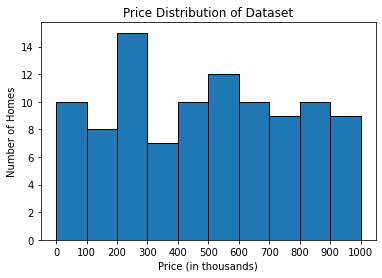

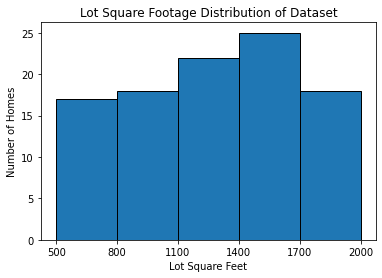

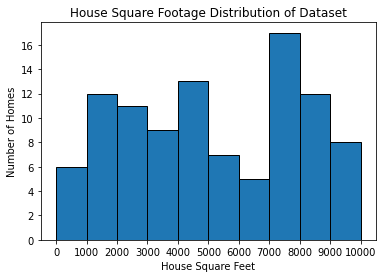

In [52]:
bins= [0,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
plt.hist(dataframe['Price'].values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('Price (in thousands)')
plt.ylabel('Number of Homes')
plt.title('Price Distribution of Dataset')

plt.show()

bins= [500, 800, 1100, 1400, 1700, 2000]
plt.hist(dataframe['Lot Square Footage'].values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('Lot Square Feet')
plt.ylabel('Number of Homes')
plt.title('Lot Square Footage Distribution of Dataset')

plt.show()

bins= [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plt.hist(dataframe['House Square Footage'].values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('House Square Feet')
plt.ylabel('Number of Homes')
plt.title('House Square Footage Distribution of Dataset')

plt.show()

In [7]:
env = RealEstateEnv(houses, Customer(1, 500000))

C:\Users\rodam\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
env.init_render()

In [ ]:
env.observation_space.sample()

In [ ]:
episodes = 10
num_customers = 10
customers = []
customers.append(Customer(1, 500000))
pygame.init()
commission = 0
goal = 50000
num_customer = 1
recession = False
rText = ["RECESSION!"]
rtextobj = env.text(rText, 30, (255, 0, 0))
commissions = pd.Dataframe()
while commission < goal:
    env.best_state = env.state
    env.best_house = env.house
    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        score = 0

        while not done:
            textArray = ["Commissions: " + str(commission),
                         "Best Fit: " + str(env.best_state),
                         "Current Fit: " + str(env.state),
                        ]
            textArray1 = ["Best Price: " + str(env.best_house.price),
                          "Best HFootage: " + str(env.best_house.house_sqft),
                          "Best Bedrooms: " + str(env.best_house.bedrooms),
                          "Best Bathrooms: " + str(env.best_house.bathrooms),
                          "Best LFootage: " + str(env.best_house.lot_sqft),
                          "Goal Price: " + str(customers[num_customer-1].price),
                          "Goal HFootage: " + str(customers[num_customer-1].house_sqft),
                          "Goal Bedrooms: " + str(customers[num_customer-1].num_bedrooms),
                          "Goal Bathrooms: " + str(customers[num_customer-1].num_bathrooms),
                          "Goal LFootage: " + str(customers[num_customer-1].lot_sqft)
                         ]
            textArray2 = ["C: " + str(customers[num_customer-1].id),
                          "E: " + str(episode)
                         ]
            text_obj = env.text(textArray, 25, (0, 0, 0))
            text_obj1 = env.text(textArray1, 17, (0, 0, 0))
            text_obj2 = env.text(textArray2, 25, (0, 0, 0))
            env.clock.tick(30)
            action = env.action_space.sample()
            env.update_customer(customers[num_customer-1])
            n_state, reward, done, info = env.step(action)
            score+=reward
            if recession:
                env.render(text_obj, text_obj1, text_obj2, rtextobj)
            else:
                env.render(text_obj, text_obj1, text_obj2, [])
            customers[num_customer-1].render(env)
            pygame.display.update()
            for eve in pygame.event.get():
                if eve.type==pygame.QUIT:
                    pygame.quit()
                    #sys.exit()
        print('Customer ID: {} Episode:{} Score:{}'.format(customers[num_customer-1].id, episode, score))
        
    num_customer += 1
    recession = False
    # commission code
    commission += round(env.best_house.price * 0.03)
    difference = abs(1 - env.best_state)
    new_price = 0
    if difference <= 0.1:
        new_price = round(env.best_house.price * (1.2 - difference*2))
    elif difference > 0.1 and difference <= 0.2:
        new_price = round(env.best_house.price * random.choice([0.9, 1.1]))
    else:
        new_price = round(env.best_house.price * (1 - difference))
    if (random.randint(0, 100) < 10): #RECESSION
        new_price *= 0.7
        recession = True
    customers.append(Customer(num_customer, new_price))
        

pygame.quit()

# 2. Create a Deep Learning Model with Keras

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
states = env.observation_space.shape
actions = env.action_space.n

In [10]:
actions

3

In [11]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [56]:
del model 

In [57]:
model = build_model(states, actions)

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 75        
Total params: 723
Trainable params: 723
Non-trainable params: 0
_________________________________________________________________


# 3. Build Agent with Keras-RL

In [59]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [60]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [95]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mse', 'mae', 'mape'])
history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

# if you get an error, go back up to the block that says "del model" and run everything below until here

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 48s 5ms/step - reward: 0.0968
55 episodes - episode_reward: 15.782 [-178.000, 180.000] - loss: 1.767 - mse: 250.973 - mae: 13.164 - mape: 12836523729.895 - mean_q: 20.729

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 47s 5ms/step - reward: 0.0622
56 episodes - episode_reward: 12.964 [-176.000, 180.000] - loss: 1.604 - mse: 149.437 - mae: 10.237 - mape: 9902580736.000 - mean_q: 17.425

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 50s 5ms/step - reward: 0.0586
55 episodes - episode_reward: 10.618 [-178.000, 180.000] - loss: 1.620 - mse: 109.203 - mae: 8.787 - mape: 8467103744.000 - mean_q: 16.062

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: 0.1792
56 episodes - episode_reward: 31.929 [-178.000, 180.000] - loss: 1.568 - mse: 99.629 - mae: 8.393 - mape

In [96]:
history.history.keys()

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])

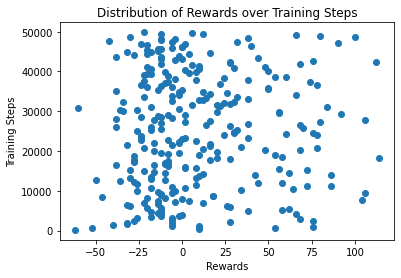

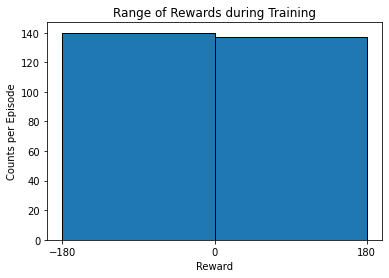

In [91]:
plt.scatter(history.history['episode_reward'], history.history['nb_steps'])
plt.xlabel('Rewards')
plt.ylabel('Training Steps')
plt.title('Distribution of Rewards over Training Steps')

plt.show()

bins= [-180, 0, 180]
plt.hist(history.history['episode_reward'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('Reward')
plt.ylabel('Counts per Episode')
plt.title('Range of Rewards during Training')

plt.show()

In [81]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 2.000, steps: 180
Episode 2: reward: 2.000, steps: 180
Episode 3: reward: -172.000, steps: 180
Episode 4: reward: 176.000, steps: 180
Episode 5: reward: 174.000, steps: 180
Episode 6: reward: 180.000, steps: 180
Episode 7: reward: 180.000, steps: 180
Episode 8: reward: 0.000, steps: 180
Episode 9: reward: 180.000, steps: 180
Episode 10: reward: 2.000, steps: 180
Episode 11: reward: 180.000, steps: 180
Episode 12: reward: 178.000, steps: 180
Episode 13: reward: 2.000, steps: 180
Episode 14: reward: 174.000, steps: 180
Episode 15: reward: 180.000, steps: 180
Episode 16: reward: 2.000, steps: 180
Episode 17: reward: 2.000, steps: 180
Episode 18: reward: -154.000, steps: 180
Episode 19: reward: -158.000, steps: 180
Episode 20: reward: -156.000, steps: 180
Episode 21: reward: 2.000, steps: 180
Episode 22: reward: 2.000, steps: 180
Episode 23: reward: -178.000, steps: 180
Episode 24: reward: 0.000, steps: 180
Episode 25: reward: 0.000, steps: 1

In [85]:
scores.params

{'nb_episodes': 100}

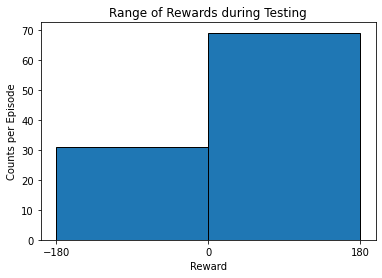

In [88]:
bins= [-180, 0, 180]
plt.hist(scores.history['episode_reward'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('Reward')
plt.ylabel('Counts per Episode')
plt.title('Range of Rewards during Testing')

plt.show()

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env